In [212]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import dateutil

In [213]:
metab_file_grouping = pd.read_csv(r'..\data\metadata\metabolomics_file_grouping.csv', index_col = 0)
tf = pd.read_csv(r'..\data\interim\tf_raw_cleaned_metimp_imputed.csv', index_col=0)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_to_tolerance_dict = {1076: 'diabetic', 1082: 'diabetic',1101: 'diabetic',
                            1060: 'impaired', 1062: 'impaired', 1074: 'impaired',
                            1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal',}

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

In [254]:
msdial_neg_path = Path(r'..\data\raw\metabolomics\msdial_v2\neg_results\neg_results_with_gap_fill_compulsion.txt')
msdial_neg = pd.read_csv(msdial_neg_path, sep='\t', skiprows=4, index_col=0)

neg = pd.read_csv(r'..\data\processed\metabolomics_msdial_imputed_filtered.csv', index_col=0)
# Retain the column names, which corresponds to the original MS-Dial feature index. 
feature_indexes = {i: int(col) for i, col in enumerate(neg.columns)}
# display(neg)
raw_data = neg.filter(regex='HILIC_T', axis=0)

groups = metab_file_grouping.loc[metab_file_grouping['quant_file']][['File Name', 'animal', 'week', 'bg_type', 'gluc_tol']]
groups[['animal', 'week']] = groups[['animal', 'week']].astype('int') 
groups = groups.set_index('File Name')
# display(groups)

raw_data = pd.merge(raw_data, groups, how='inner',
                   left_on=raw_data.index, right_on='File Name').set_index('File Name')
# display(raw_data)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])

# With scaling, because standardization or normalization is important for PCA
pca_data = pipeline.fit_transform(raw)  ###### 2**raw gives the original data, not log2 transformed  ######
pca_object = pipeline.steps[1][1]
columns = ['pc' + str(x) for x in range(1, fitted.shape[1] + 1)]
pca_data = pd.DataFrame(pca_data, columns=columns)
pca_data.index = raw_data.index
pca_data = pd.concat([pca_data, raw_data[['animal', 'week', 'bg_type', 'gluc_tol']]], axis=1)
# display(pca_data)

loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_))
loadings = loadings.sort_values(0, ascending=False)
# plt.bar(np.arange(loadings.shape[1]), loadings[:, 0])

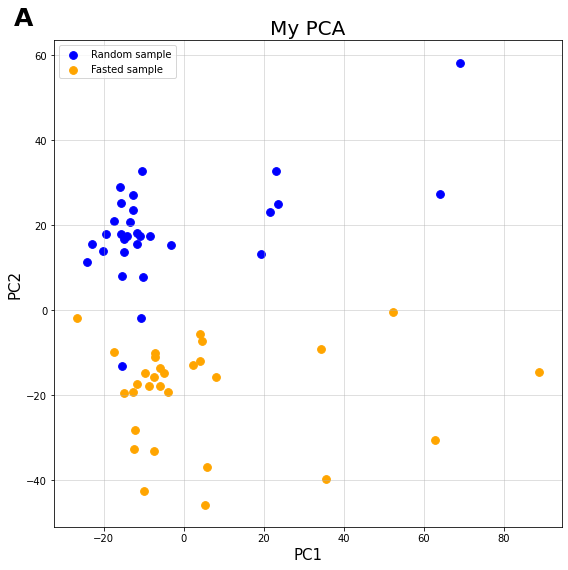

In [205]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('My PCA', fontsize=20)

targets = ['RBG', 'FBG']
weeks = [8, 9, 10]
target_colors = ['blue', 'orange']
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for target, color in zip(targets, target_colors):
    points = pca_data.loc[pca_data['bg_type'] == target]
    ax.scatter(points['pc1'], points['pc2'],
               c=color, cmap='viridis', s=60)
ax.legend(['Random sample', 'Fasted sample'])
ax.grid(alpha=0.5)

ax.text(-0.08, 1.03, "A", transform=ax.transAxes, fontsize=25, weight='bold')

plt.tight_layout()



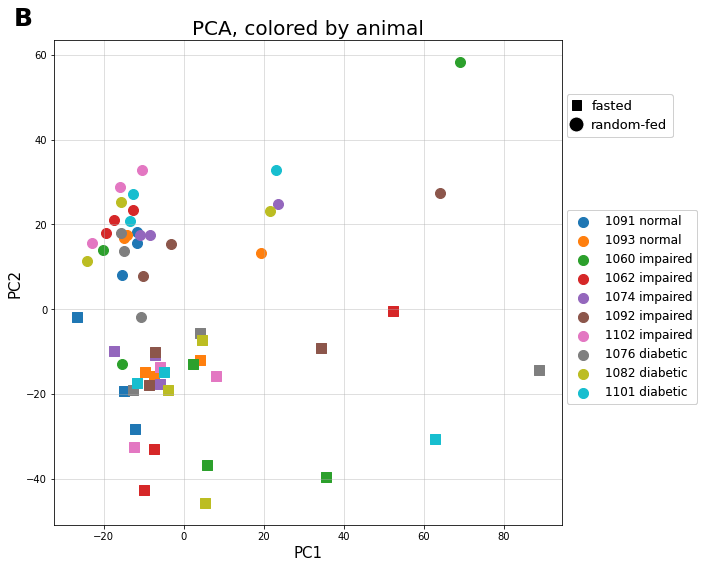

In [262]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, colored by animal', fontsize = 20)
targets = ['RBG', 'FBG']
weeks = [8, 9, 10]
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

handles = []

for target, marker in zip(targets, markers):
    for label, color in zip(animals_used, colors):
        scatter_points = pca_data[(pca_data['bg_type'] == target) & \
                                  (pca_data['animal'] == label)]
#             print(scatter_points)
        handle = ax.scatter(scatter_points['pc1'],
                            scatter_points['pc2'],
                            c = color,
#                             cmap='viridis',
                            marker=marker,
                            s = (110 if marker == 's' else 100))

        # Annotate the plot with number for week 8, 9, 10 (convert to 1, 2, 3 for ease of reading)
#         for index, row in scatter_points.iterrows():
#             week = row['week'] - 7  # Minus 7 to go from week 8->1, 9->2, 10->3
#             ax.annotate(str(week), xy=(row['pc1']-0.5, row['pc2']-0.7), 
#                         fontsize=8, color='white', weight='bold')

        # define the text label for the data handle for the legend:
        gluc_tol = animal_phenotypes[animal_phenotypes['animal'] == label]['glucose_tolerance'].values[0]
        handle.set_label(str(label) + ' ' + gluc_tol)
        handles.append(handle)
        
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

legend_labels = []
for animal in animals_used:
    animal_data = animal_phenotypes[animal_phenotypes['animal'] == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])

handles, labels = ax.get_legend_handles_labels()

# print(handles, labels)
# legend = ax.legend(handles, labels, loc=(1.01, 0.23))

legend = ax.legend(handles[:10], labels[:10], loc=(1.01, 0.25), fontsize=12)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))

legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                             Line2D([0], [0], marker='o', color='white', label='random-fed', 
                                    markerfacecolor='black', markersize=15)], 
                    loc=(1.01, 0.8), 
                    fontsize=13, 
                    handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))
ax.add_artist(legend)
# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')])

ax.text(-0.08, 1.03, "B", transform=ax.transAxes, fontsize=25, weight='bold')
# ax.text(1.072, 0.87, "Animal, feeding, glucose tolerance", transform=ax.transAxes, fontsize=9)

plt.tight_layout()

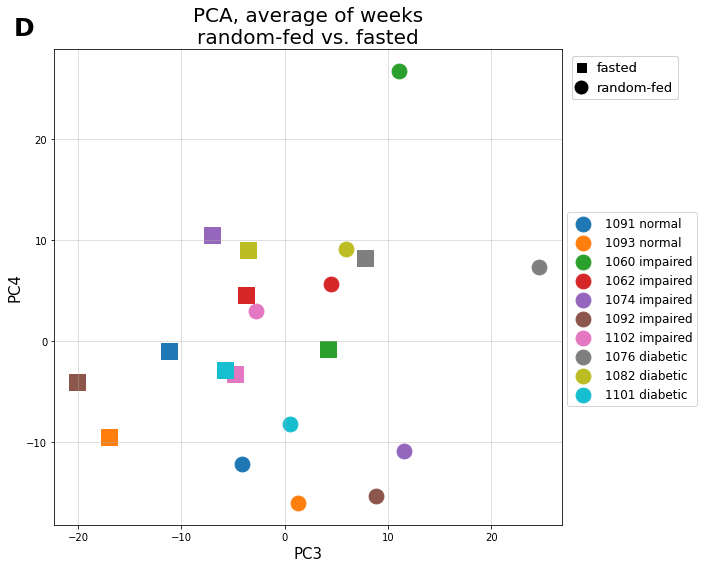

In [269]:
pc_to_plot_x = 3
pc_to_plot_y = 4

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC' + str(pc_to_plot_x), fontsize = 15)
ax.set_ylabel('PC' + str(pc_to_plot_y), fontsize = 15)
ax.set_title('PCA, average of weeks\nrandom-fed vs. fasted', fontsize = 20)

markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

handles = []


for rat_label, color in zip(animals_used, colors):
    for bg_type, marker in zip(['RBG', 'FBG'], markers):
        tolerance_type = animal_to_tolerance_dict[rat_label]
        edge_color = None
        if tolerance_type == 'diabetic':
            edge_color = 'lightgray'
        elif tolerance_type == 'impaired':
            edge_color = 'darkgray'
        else: 
            edge_color = 'black'

        scatter_points = pca_data[(pca_data['gluc_tol'] == tolerance_type) & \
                                  (pca_data['animal'] == (rat_label)) & \
                                  (pca_data['bg_type'] == bg_type)].mean(axis=0)
        handle = ax.scatter(scatter_points['pc' + str(pc_to_plot_x)],
                            scatter_points['pc' + str(pc_to_plot_y)],
                            c = color,
                            marker=marker,
#                             edgecolors=edge_color,
#                             linewidths=3,              # linewidths is stroke size of marker outline
                            s = (250 if marker == 's' else 220),
                            )
#         # Annotate the plot with letter for Diabetic, Normal, Impaired
#         ax.annotate(tolerance_type[0].upper(), 
#                     xy=(scatter_points['pc1']-0.5, scatter_points['pc2']-0.7), 
#                     fontsize=20,
#                     color='black')
    
        # define the text label for the data handle for the legend:
#         gluc_tol = animal_phenotypes[animal_phenotypes['animal'] == rat_label]['glucose_tolerance'].values[0]
        handle.set_label(str(rat_label) + ' ' + tolerance_type )
        handles.append(handle)
        
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

legend_labels = []
for animal in animals_used:
    animal_data = animal_phenotypes[animal_phenotypes['animal'] == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])

handles, labels = ax.get_legend_handles_labels()

# print(handles, labels)
legend = ax.legend(handles[::2], labels[::2], loc=(1.01, 0.25), fontsize=12)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))

legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                   Line2D([0], [0], marker='o', color='white', label='random-fed', 
                          markerfacecolor='black', markersize=15)], loc=(1.02, 0.895), fontsize=13, handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)

# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')], loc=(1.01, 0.98))

ax.text(-0.08, 1.03, "D", transform=ax.transAxes, fontsize=25, weight='bold')

plt.tight_layout()

In [208]:
loadings

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
956,0.947372,0.164896,0.003351,-0.046363,0.150451,0.018436,0.011675,-0.087371,-0.036937,0.109677,...,0.040457,0.030327,0.044355,0.007994,0.005473,-0.023546,-0.053193,0.018079,0.020911,3.672528e-17
983,0.932449,0.176616,-0.063357,-0.035710,0.172600,0.071149,0.058796,-0.084483,-0.023847,0.074948,...,0.018988,0.022815,0.063574,-0.041062,0.058828,0.039913,-0.044265,-0.028993,0.015416,7.005620e-17
2101,0.866892,0.104880,0.130517,-0.191182,0.131987,0.017784,-0.033441,-0.009562,-0.104847,-0.012171,...,0.048174,0.025148,0.043206,0.031202,0.029800,0.038189,-0.016285,0.052638,-0.034312,1.324718e-17
620,0.858395,0.177486,-0.079699,-0.195851,0.213790,0.128413,-0.136789,-0.097884,0.057852,0.076222,...,0.016763,-0.003567,-0.036500,0.003199,0.026112,0.016180,-0.026831,-0.018366,-0.059273,2.412720e-17
619,0.854304,0.182676,-0.034662,-0.262832,0.237064,0.134636,-0.085370,-0.065704,0.020996,0.030903,...,0.001898,0.035143,0.038589,0.016540,0.062565,-0.040074,0.031569,-0.038848,0.042935,-1.249513e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,-0.937437,-0.240434,-0.001205,-0.109553,0.040525,0.000145,-0.118585,-0.079714,-0.041623,0.039193,...,0.000624,-0.015497,0.035792,0.007865,-0.011670,-0.024885,-0.004807,-0.000418,0.000134,-1.244118e-17
2157,-0.937923,-0.079514,-0.127725,0.071980,-0.146518,0.003241,-0.128730,-0.101012,-0.019275,0.030961,...,-0.001796,-0.008865,-0.016905,-0.029677,-0.012127,0.004154,-0.022373,0.009694,-0.027687,1.076115e-16
2478,-0.940428,0.001693,-0.148200,0.017949,-0.001961,-0.016798,-0.108819,-0.102351,-0.042782,0.056875,...,0.053986,-0.019338,-0.032983,0.031702,0.007618,0.044351,-0.074696,-0.018214,-0.052464,2.739106e-17
144,-0.950719,0.118696,0.132381,0.082881,-0.099241,-0.020742,-0.013418,0.054944,0.036122,-0.011888,...,-0.018058,0.006808,0.008614,-0.033978,0.031501,0.002978,0.025339,-0.022853,0.031564,-6.800949e-18


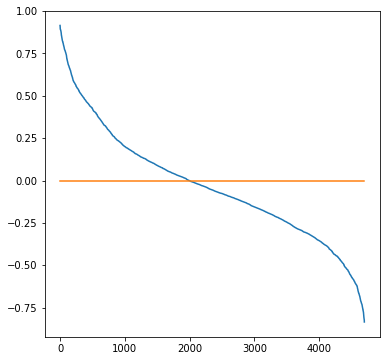

In [256]:
pc_of_interest = 1  # Add 1 to this number to get the pc 

loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_))
loadings = loadings.rename(feature_indexes)
loadings = loadings.sort_values(pc_of_interest, ascending=False)
# loadings[0]
plt.figure(figsize=(6,6))
plt.plot(np.arange(raw.shape[1]), loadings[pc_of_interest])
plt.plot([0, raw.shape[1]], [0, 0], )

In [259]:
high_corr_feats = loadings.loc[loadings[pc_of_interest] > 0.8]
high_neg_corr_feats = loadings.loc[loadings[pc_of_interest] < -0.75]
# high_neg_corr_feats

In [258]:
msdial_neg.loc[high_corr_feats.index]

,Average Rt(min),Average Mz,Metabolite name,Adduct type,Post curation result,Fill %,MS/MS assigned,Reference RT,Reference m/z,Formula,...,N_F,N_R,zzblank.1,zhuman_qc.1,I_F.1,I_R.1,D_F.1,D_R.1,N_F.1,N_R.1
16773,2.532,561.32996,w/o MS2:MGMG 18:2,[M-H]-,ion correlated with 16769,0.925,True,NaN,561.32898,C27H48O9,...,7.826226e+07,1.486547e+08,0.000000e+00,3.872175e+06,3.769908e+07,4.718684e+07,2.153021e+07,3.182277e+07,4.012337e+07,2.812096e+07
18137,2.532,859.53198,w/o MS2:PI 36:3,[M-H]-,NaN,0.358,False,NaN,859.53271,C45H81O13P,...,1.454629e+06,3.162808e+06,0.000000e+00,1.756387e+06,1.055737e+06,1.629916e+06,4.794793e+05,8.334010e+05,8.697134e+05,7.568821e+05
15950,3.405,476.27716,LPE 18:2,[M-H]-,NaN,0.060,True,NaN,476.27609,C23H44NO7P,...,1.965175e+06,4.999186e+06,0.000000e+00,3.164689e+05,1.219911e+06,3.746652e+06,5.784584e+05,2.429292e+06,1.599695e+06,1.943311e+06
15962,2.859,478.29349,w/o MS2:LPE 18:1,[M-H]-,NaN,0.015,False,NaN,478.29419,C23H46NO7P,...,2.583761e+06,5.550829e+06,0.000000e+00,1.994389e+06,1.443884e+06,2.220876e+06,4.605928e+05,1.177745e+06,2.168658e+06,1.322144e+06
15961,2.795,478.29327,LPE 18:1,[M-H]-,NaN,0.373,True,NaN,478.29419,C23H46NO7P,...,2.973948e+06,6.631130e+06,0.000000e+00,1.323967e+06,1.897138e+06,2.628556e+06,6.157562e+05,1.326086e+06,2.762345e+06,1.370237e+06
16238,2.532,504.30878,Unknown,[M-H]-,similar chromatogram in higher mz_18151,0.672,True,NaN,NaN,NaN,...,3.159932e+06,5.351261e+06,0.000000e+00,2.788121e+05,1.521320e+06,2.053561e+06,9.166857e+05,1.304737e+06,2.686180e+06,1.147899e+06
18150,2.470,861.54858,PI 36:2,[M-H]-,NaN,0.060,True,NaN,861.55042,C45H83O13P,...,3.146569e+06,1.075900e+07,0.000000e+00,8.639006e+06,3.220787e+06,7.805771e+06,1.447981e+06,4.252987e+06,2.953741e+06,3.145125e+06
16905,2.529,579.34869,"w/o MS2:(1S,2S,5R,7R,10S,11S,14R,16R,19S,20S,2...",[M-H]-,ion correlated with 16906,0.090,False,NaN,579.35382,C32H52O9,...,8.491074e+06,1.391149e+07,0.000000e+00,4.987952e+05,3.773356e+06,5.375733e+06,2.253271e+06,3.345992e+06,6.269084e+06,2.283857e+06
18151,2.531,861.54883,PI 36:2,[M-H]-,NaN,0.896,True,NaN,861.55042,C45H83O13P,...,3.678675e+06,1.228241e+07,0.000000e+00,7.593627e+06,4.188578e+06,8.520275e+06,1.764225e+06,5.529737e+06,3.526209e+06,4.169043e+06
16768,2.597,561.32947,w/o MS2:MGMG 18:2,[M-H]-,NaN,0.030,True,NaN,561.32898,C27H48O9,...,7.474005e+07,1.057552e+08,0.000000e+00,3.212574e+06,2.758311e+07,3.425650e+07,1.941969e+07,2.364340e+07,6.811982e+07,2.821717e+07


In [260]:
msdial_neg.loc[high_neg_corr_feats.index]

,Average Rt(min),Average Mz,Metabolite name,Adduct type,Post curation result,Fill %,MS/MS assigned,Reference RT,Reference m/z,Formula,...,N_F,N_R,zzblank.1,zhuman_qc.1,I_F.1,I_R.1,D_F.1,D_R.1,N_F.1,N_R.1
4772,2.237,167.10675,w/o MS2:Geranic acid,[M-H]-,NaN,0.045,False,NaN,167.10680,C10H16O2,...,2.472850e+05,6.257158e+04,1.805425e+04,2.261985e+05,3.183454e+05,1.127602e+05,6.589640e+05,1.373272e+05,1.289099e+05,5.481839e+04
14665,2.597,389.26880,w/o MS2:3oxo deoxycholic acid,[M-H]-,NaN,0.015,False,NaN,389.26971,C24H38O5,...,1.781999e+06,1.109219e+05,0.000000e+00,3.130358e+04,2.250863e+06,1.943380e+05,8.144300e+05,6.374341e+04,1.782134e+06,9.321103e+04
13727,2.123,351.21829,w/o MS2:LTB4_20-Hydroxy,[M-H]-,ion correlated with 13673,0.015,False,NaN,351.21771,C20H32O5,...,6.669620e+05,4.494252e+05,2.160475e+05,1.890387e+05,1.093200e+06,4.906149e+05,1.633132e+06,6.547884e+05,2.586969e+05,1.830943e+05
10544,1.847,269.21158,w/o MS2:Baicalein,[M-H]-,NaN,0.045,False,NaN,269.21506,C15H10O5,...,9.325634e+06,4.973494e+06,5.547327e+05,8.224620e+05,2.717319e+06,9.806903e+05,4.478848e+06,1.457932e+06,2.249042e+06,4.848543e+05
10035,1.586,257.23907,Unknown,[M-H]-,similar chromatogram in higher mz_11188; simil...,0.149,False,NaN,NaN,NaN,...,1.389786e+07,7.380126e+06,1.076920e+06,8.170269e+05,2.722571e+06,1.840322e+06,1.572010e+06,1.211514e+06,2.059840e+06,9.644830e+05
9166,9.658,243.06149,Pseudouridine,[M-H]-,ion correlated with 9167,0.224,True,NaN,243.06210,C9H12N2O6,...,1.536775e+06,9.560271e+05,0.000000e+00,3.175373e+05,3.143282e+05,2.968554e+05,4.228643e+05,1.030250e+05,1.969062e+05,1.882505e+05
12308,3.007,311.22223,w/o MS2:9-HPODE,[M-H]-,ion correlated with 12302,0.313,True,NaN,311.22278,C18H32O4,...,3.281931e+06,1.436099e+06,0.000000e+00,2.740710e+05,1.419286e+06,4.650179e+05,9.036501e+05,3.830022e+05,9.794835e+05,2.435940e+05
14704,3.079,391.28461,w/o MS2:Hyodeoxycholic acid,[M-H]-,NaN,0.209,False,NaN,391.28458,C24H40O4,...,6.236982e+06,1.357619e+06,0.000000e+00,1.766058e+05,4.049051e+06,1.507425e+06,1.733508e+06,4.719839e+05,3.506129e+06,6.395484e+05
9891,1.586,255.23239,w/o MS2:Palmitic acid,[M-H]-,found in higher mz's MsMs_18044,0.224,False,NaN,255.23219,C16H32O2,...,1.035836e+09,5.603686e+08,4.683096e+07,2.398906e+07,2.037880e+08,1.257464e+08,8.558657e+07,8.492854e+07,1.257752e+08,3.307574e+07
6177,7.473,192.06570,w/o MS2:2-METHYLHIPPURIC ACID,[M-H]-,ion correlated with 6175; ion correlated with ...,0.328,True,NaN,192.06662,C10H11NO3,...,8.488377e+05,3.631153e+05,0.000000e+00,5.539551e+03,9.105895e+05,2.724975e+05,4.556495e+05,7.822410e+05,2.388670e+05,1.145851e+05


In [64]:
scaled_pca.explained_variance_ratio_ * 100

array([1.26779539e+01, 1.05978931e+01, 5.95235132e+00, 4.46714833e+00,
       3.54929073e+00, 3.16084787e+00, 2.82192322e+00, 2.53529809e+00,
       2.20279497e+00, 2.11626499e+00, 1.97992812e+00, 1.90602610e+00,
       1.76100850e+00, 1.62738762e+00, 1.55238263e+00, 1.50133523e+00,
       1.42014721e+00, 1.37288697e+00, 1.32648841e+00, 1.30505282e+00,
       1.25054395e+00, 1.21296098e+00, 1.18705608e+00, 1.16211296e+00,
       1.13814974e+00, 1.10636299e+00, 1.07439870e+00, 1.05552019e+00,
       1.04438033e+00, 1.01348664e+00, 1.00518136e+00, 9.79213548e-01,
       9.64361392e-01, 9.49865669e-01, 9.39512621e-01, 9.06852491e-01,
       8.75979114e-01, 8.65554442e-01, 8.53946602e-01, 8.38333405e-01,
       8.27359528e-01, 8.17258117e-01, 8.03341563e-01, 7.98938688e-01,
       7.78976985e-01, 7.64617367e-01, 7.59008825e-01, 7.42662033e-01,
       7.34900638e-01, 7.16037156e-01, 7.10646662e-01, 7.05556332e-01,
       6.91334189e-01, 6.84426250e-01, 6.75385217e-01, 6.61749914e-01,
      

In [65]:
scaled_pca.transform(raw)

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[-502.08224795, -162.2559385 ,  100.48756722, ...,   81.84552975,
         -27.38209051,   15.29841682],
       [-558.2803483 , -133.0643931 ,  122.47837146, ...,   81.47444163,
         -20.75234636,   17.32253658],
       [-535.5035129 , -157.37696667,   90.63080929, ...,   78.93593461,
         -16.1480204 ,   17.37327474],
       ...,
       [-555.32287811,  -81.01370265,   64.84482592, ...,   91.02304214,
         -21.56449882,   17.19799744],
       [-558.47023012,  -89.05576844,   71.02648532, ...,   87.01182004,
         -26.28693296,   18.70141387],
       [-557.18459204,  -94.95783324,   66.86511638, ...,   86.10653503,
         -16.95258294,   17.2595654 ]])


Prediction accuracy for the normal test dataset with PCA
81.48%


Prediction accuracy for the standardized test dataset with PCA
98.15%


PC 1 without scaling:
[ 1.76342917e-03 -8.35544737e-04  1.54623496e-04 -5.31136096e-03
  2.01663336e-02  1.02440667e-03  1.53155502e-03 -1.11663562e-04
  6.31071580e-04  2.32645551e-03  1.53606718e-04  7.43176482e-04
  9.99775716e-01]

PC 1 with scaling:
[ 0.13443023 -0.25680248 -0.0113463  -0.23405337  0.15840049  0.39194918
  0.41607649 -0.27871336  0.33129255 -0.11383282  0.29726413  0.38054255
  0.27507157]


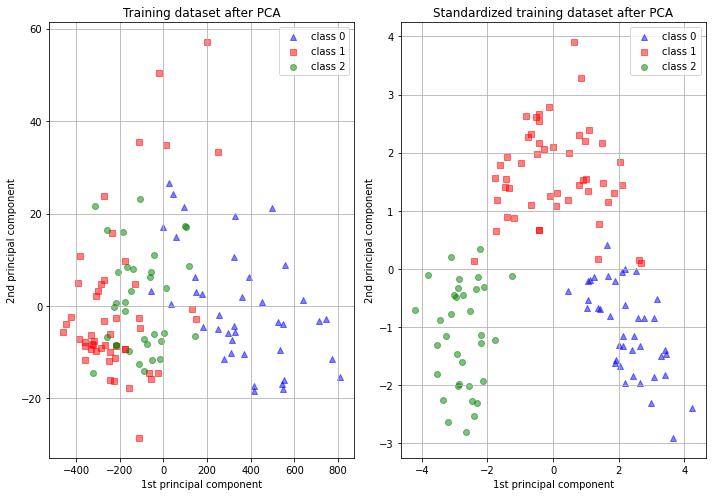

[[-1.57493066e+02 -9.72073994e+00]
 [-6.55815952e+01 -1.45609134e+01]
 [ 1.34604914e+01  3.47497491e+01]
 [ 1.42908813e+02  6.16953262e+00]
 [-4.47424342e+02 -3.94649179e+00]
 [ 2.97686791e+02 -5.92813757e+00]
 [-3.22623800e+02 -1.44093687e+01]
 [-3.09502337e+02 -9.74428498e+00]
 [-1.82426147e+01  5.04147463e+01]
 [-5.25068449e+01 -1.17783912e+01]
 [ 5.42511556e+02 -1.68298847e+01]
 [ 5.52543157e+02 -1.60723223e+01]
 [ 5.47484726e+02 -1.79381096e+01]
 [ 1.17938490e+02  8.75321686e+00]
 [-1.92744988e+00  1.71847248e+01]
 [ 2.52753114e+02 -2.01076056e+00]
 [ 2.00920391e+02  5.70596683e+01]
 [-2.27316086e+02 -3.26365887e-01]
 [-3.09262990e+02  2.25178477e+00]
 [ 7.72659318e+02 -1.14181218e+01]
 [-1.12551148e+02 -1.25646160e+01]
 [-3.57502978e+02 -7.69176277e+00]
 [ 3.28215810e+02  1.94596248e+01]
 [-2.17322032e+02  5.47555141e-01]
 [-3.85490553e+02 -7.09555449e+00]
 [-3.82121436e+02  1.07686496e+01]
 [ 1.47841341e+02  3.10737236e+00]
 [-1.11593637e+02  3.53766643e+01]
 [ 1.77821871e+02  2

In [68]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline

# Code source: Tyler Lanigan <tylerlanigan@gmail.com>
#              Sebastian Raschka <mail@sebastianraschka.com>

# License: BSD 3 clause

RANDOM_STATE = 42
FIG_SIZE = (10, 7)


features, target = load_wine(return_X_y=True)

# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.30, random_state=RANDOM_STATE
)

# Fit to data and predict using pipelined GNB and PCA
unscaled_clf = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB and PCA
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

# Show prediction accuracies in scaled and unscaled data.
print("\nPrediction accuracy for the normal test dataset with PCA")
print(f"{accuracy_score(y_test, pred_test):.2%}\n")

print("\nPrediction accuracy for the standardized test dataset with PCA")
print(f"{accuracy_score(y_test, pred_test_std):.2%}\n")

# Extract PCA from pipeline
pca = unscaled_clf.named_steps["pca"]
pca_std = std_clf.named_steps["pca"]

# Show first principal components
print(f"\nPC 1 without scaling:\n{pca.components_[0]}")
print(f"\nPC 1 with scaling:\n{pca_std.components_[0]}")

# Use PCA without and with scale on X_train data for visualization.
X_train_transformed = pca.transform(X_train)

scaler = std_clf.named_steps["standardscaler"]
scaled_X_train = scaler.transform(X_train)
X_train_std_transformed = pca_std.transform(scaled_X_train)

# visualize standardized vs. untouched dataset with PCA performed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)

target_classes = range(0, 3)
colors = ("blue", "red", "green")
markers = ("^", "s", "o")

for target_class, color, marker in zip(target_classes, colors, markers):
    ax1.scatter(
        x=X_train_transformed[y_train == target_class, 0],
        y=X_train_transformed[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5,
        marker=marker,
    )
    

    ax2.scatter(
        x=X_train_std_transformed[y_train == target_class, 0],
        y=X_train_std_transformed[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5,
        marker=marker,
    )

ax1.set_title("Training dataset after PCA")
ax2.set_title("Standardized training dataset after PCA")

for ax in (ax1, ax2):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()

plt.tight_layout()

plt.show()

print(X_train_transformed)